In [82]:
from get_data import fetch_data
import tiktoken
import matplotlib.pyplot as plt

In [2]:
train_data, val_data = fetch_data()
print(len(train_data))

/home/ubuntu/miniconda3/envs/HW3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/envs/HW3/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
Extracting data files: 100%|██████████| 1/1 [00:10<00:00, 10.32s/it]
Generating train split: 296821 examples [00:03, 80313.48 examples/s]

281979


In [18]:
def get_word_count(dataset):
    total_words = sum([len(i['text'].split(' ')) for i in dataset])
    return total_words

In [19]:
total_words = get_word_count(train_data)

In [20]:
print(f"Total Words: {total_words}")

220972724


In [61]:
tokenizer = tiktoken.get_encoding('gpt2')

tokenised_text = tokenizer.encode(train_data[0]['text'])

list

In [70]:
def tokenise(sample):
    tokenised_text = tokenizer.encode(sample['text'])
    tokenised_text.append(tokenizer.eot_token)
    return {"tokenised_text": tokenised_text}    

In [71]:
train_data_tokenised = train_data.map(tokenise)

Map: 100%|██████████| 281979/281979 [06:33<00:00, 715.88 examples/s]


In [72]:
print(train_data_tokenised)

Dataset({
    features: ['text', 'timestamp', 'url', 'tokenised_text'],
    num_rows: 281979
})


In [77]:
def get_token_counts(dataset):
    total_tokens = sum([len(i['tokenised_text']) for i in dataset])
    return total_tokens

In [79]:
total_tokens = get_token_counts(train_data_tokenised)

In [80]:
print(total_tokens)

499243490


In [85]:
def plot_document_size_hist(dataset):
    token_counts = [len(i) for i in dataset['tokenised_text']]
    print(f"Minimum Token Count: {min(token_counts)}")
    print(f"Maximum token Count: {max(token_counts)}")
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts, bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Document Sizes (Number of Tokens)')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Number of Documents')
    plt.grid(axis='y', alpha=0.75)

    # Showing the histogram
    plt.show()

Minimum Token Count: 2
Maximum token Count: 212721


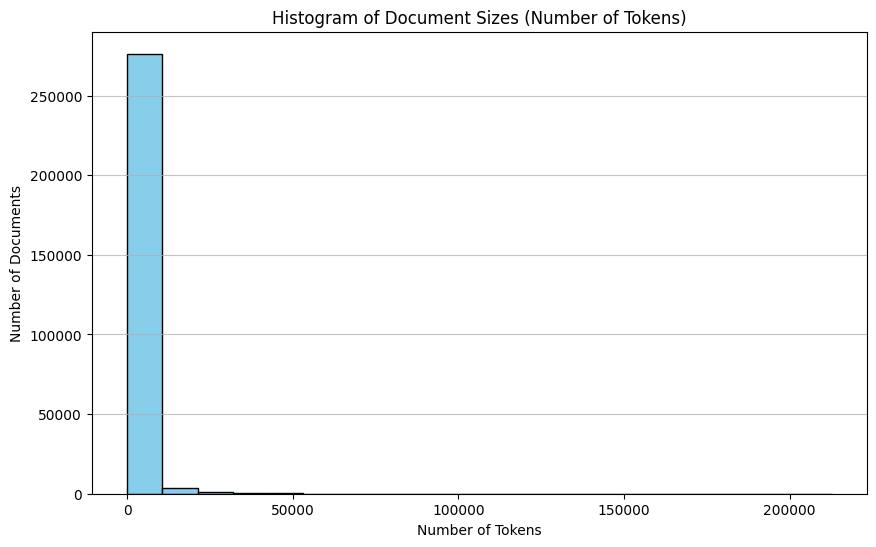

In [87]:
plot_document_size_hist(train_data_tokenised)